In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import random
import gym
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import pygame
from math import pi, sin, cos, sqrt
from random import randrange
from gym import spaces
from pygame.locals import *
import matplotlib.pyplot as plt
import pylab


class droneEnv(gym.Env):
    def __init__(self, render_every_frame, mouse_target):
        super(droneEnv, self).__init__()

        self.render_every_frame = render_every_frame
        # Makes the target follow the mouse
        self.mouse_target = mouse_target

        # Initialize Pygame, load sprites
        pygame.init()
        self.screen = pygame.display.set_mode((800, 800))
        self.FramePerSec = pygame.time.Clock()

        self.player = pygame.image.load(os.path.join("/home/cbeario/DeepPrior/Flight_UAV/background/drone_old.png"))
        self.player.convert()

        self.target = pygame.image.load(os.path.join("/home/cbeario/DeepPrior/Flight_UAV/background/target_old.png"))
        self.target.convert()

        pygame.font.init()
        self.myfont = pygame.font.SysFont("Comic Sans MS", 20)

        # Physics constants
        self.FPS = 60
        self.gravity = 0.08
        self.thruster_amplitude = 0.04
        self.diff_amplitude = 0.0006
        self.thruster_mean = 0.04
        self.mass = 1
        self.arm = 25
        self.target_counter = 0

        # Initialize variables
        (self.a, self.ad, self.add) = (0, 0, 0)
        (self.x, self.xd, self.xdd) = (400, 0, 0)
        (self.y, self.yd, self.ydd) = (400, 0, 0)
        self.xt = randrange(200, 600)
        self.yt = randrange(200, 600)

        # Initialize game variables
        #self.target_counter = 0
        self.reward = 0
        self.time = 0
        self.time_limit = 20
        if self.mouse_target is True:
            self.time_limit = 1000

        # 5 actions: Nothing, Up, Down, Right, Left
        self.action_space = gym.spaces.Discrete(5)
        # 8 observations: angle_to_up, velocity, angle_velocity, distance_to_target, angle_to_target, angle_target_and_velocity, distance_to_target
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(7,))

    def reset(self):
        # Reset variables
        (self.a, self.ad, self.add) = (0, 0, 0)
        (self.x, self.xd, self.xdd) = (400, 0, 0)
        (self.y, self.yd, self.ydd) = (400, 0, 0)
        self.xt = randrange(200, 600)
        self.yt = randrange(200, 600)

        #self.target_counter = 0
        self.reward = 0
        self.time = 0

        return self.get_obs()

    def get_obs(self) -> np.ndarray:

        angle_to_up = self.a / 180 * pi
        velocity = sqrt(self.xd**2 + self.yd**2)
        angle_velocity = self.ad
        distance_to_target = (
            sqrt((self.xt - self.x) ** 2 + (self.yt - self.y) ** 2) / 500
        )
        angle_to_target = np.arctan2(self.yt - self.y, self.xt - self.x)
        # Angle between the to_target vector and the velocity vector
        angle_target_and_velocity = np.arctan2(
            self.yt - self.y, self.xt - self.x
        ) - np.arctan2(self.yd, self.xd)
        distance_to_target = (
            sqrt((self.xt - self.x) ** 2 + (self.yt - self.y) ** 2) / 500
        )
        return np.array(
            [
                angle_to_up,
                velocity,
                angle_velocity,
                distance_to_target,
                angle_to_target,
                angle_target_and_velocity,
                distance_to_target,
            ]
        ).astype(np.float32)

    def step(self, action):
        # Game loop
        self.reward = 0.0
        action = int(action)

        # Act every 5 frames
        for _ in range(5):
            self.time += 1 / 60

            if self.mouse_target is True:
                self.xt, self.yt = pygame.mouse.get_pos()

            # Initialize accelerations
            self.xdd = 0
            self.ydd = self.gravity
            self.add = 0
            thruster_left = self.thruster_mean
            thruster_right = self.thruster_mean

            if action == 0:
                pass
            elif action == 1:
                thruster_left += self.thruster_amplitude
                thruster_right += self.thruster_amplitude
            elif action == 2:
                thruster_left -= self.thruster_amplitude
                thruster_right -= self.thruster_amplitude
            elif action == 3:
                thruster_left += self.diff_amplitude
                thruster_right -= self.diff_amplitude
            elif action == 4:
                thruster_left -= self.diff_amplitude
                thruster_right += self.diff_amplitude

            # Calculating accelerations with Newton's laws of motions
            self.xdd += (
                -(thruster_left + thruster_right) * sin(self.a * pi / 180) / self.mass
            )
            self.ydd += (
                -(thruster_left + thruster_right) * cos(self.a * pi / 180) / self.mass
            )
            self.add += self.arm * (thruster_right - thruster_left) / self.mass

            self.xd += self.xdd
            self.yd += self.ydd
            self.ad += self.add
            self.x += self.xd
            self.y += self.yd
            self.a += self.ad

            dist = sqrt((self.x - self.xt) ** 2 + (self.y - self.yt) ** 2)

            # Reward per step survived
            self.reward += 1 / 60
            # Penalty according to the distance to target
            self.reward -= dist / (100 * 60)

            if dist < 50:
                # Reward if close to target
                self.xt = randrange(200, 600)
                self.yt = randrange(200, 600)
                self.reward += 100
                self.target_counter+=1

            # If out of time
            if self.time > self.time_limit:
                done = True
                break

            # If too far from target (crash)
            elif dist > 1000:
                self.reward -= 1000
                done = True
                break

            else:
                done = False

            if self.render_every_frame is True:
                self.render("yes")

        info = {}

        return (
            self.get_obs(),
            self.reward,
            done,
            info,
        )

    def render(self, mode):
        # Pygame rendering
        pygame.event.get()
        self.screen.fill(0)
        self.screen.blit(
            self.target,
            (
                self.xt - int(self.target.get_width() / 2),
                self.yt - int(self.target.get_height() / 2),
            ),
        )
        player_copy = pygame.transform.rotate(self.player, self.a)
        self.screen.blit(
            player_copy,
            (
                self.x - int(player_copy.get_width() / 2),
                self.y - int(player_copy.get_height() / 2),
            ),
        )

        textsurface = self.myfont.render(
            "Collected: " + str(self.target_counter), False, (255, 255, 255)
        )
        self.screen.blit(textsurface, (20, 20))
        textsurface3 = self.myfont.render(
            "Time: " + str(int(self.time)), False, (255, 255, 255)
        )
        self.screen.blit(textsurface3, (20, 50))

        pygame.display.update()
        self.FramePerSec.tick(self.FPS)

    def close(self):
        pygame.quit()


class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.EPISODES = 300
        self.memory = deque(maxlen=2000)

        self.gamma = 0.5  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.999
        self.batch_size = 64
        self.train_start = 1000
        self.max_episode_steps=1000
        self.scores, self.episodes, self.average = [], [], []
        # create main model
        self.model = Net(self.state_size, self.action_size)
        self.optimizer = optim.RMSprop(self.model.parameters(), lr=0.00025)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.train_start:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

    def act(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            with torch.no_grad():
                action_values = self.model(state)
                return action_values[0].argmax(dim=1).item()  # Ensure action_values has the correct dimension

    def PlotModel(self, score, episode):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores) / len(self.scores))
        pylab.plot(self.episodes, self.average, 'r')
        pylab.plot(self.episodes, self.scores, 'b')
        pylab.ylabel('Score', fontsize=18)
        pylab.xlabel('Steps', fontsize=18)
        dqn = 'DQN_'
        softupdate = ''
        try:
            pylab.savefig("DNARL_Drone_1.png")
        except OSError:
            pass

        return str(self.average[-1])[:5]


    def replay(self):
        if len(self.memory) < self.train_start:
            return
        minibatch = random.sample(self.memory, min(len(self.memory), self.batch_size))

        states = torch.zeros((len(minibatch), self.state_size))
        next_states = torch.zeros((len(minibatch), self.state_size))
        actions = torch.zeros(len(minibatch), dtype=torch.long)
        rewards = torch.zeros(len(minibatch))
        dones = torch.zeros(len(minibatch), dtype=torch.bool)

        for idx, (state, action, reward, next_state, done) in enumerate(minibatch):
            states[idx] = torch.FloatTensor(state)
            next_states[idx] = torch.FloatTensor(next_state)
            actions[idx] = action
            rewards[idx] = reward
            dones[idx] = done

        current_q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.model(next_states).max(1)[0]
        expected_q_values = rewards + self.gamma * next_q_values * (~dones)

        loss = nn.functional.mse_loss(current_q_values, expected_q_values.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
   

    def train(self):
        for e in range(self.EPISODES):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            while not done:
                self.env.render('human')
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                if not done or i == self.max_episode_steps - 1:
                    reward = reward
                else:
                    reward = -100
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1
                if done:
                    average = self.PlotModel(i, e)
                    print(f"episode: {e}/{self.EPISODES}, score: {i}, e: {self.epsilon:.2}, average: {average}")
                    if i == self.EPISODES-1:
                        print("Saving trained model as drone-dqn.pt")
                        torch.save(self.model.state_dict(), "drone-dqn.pt")
                self.replay()

    def test(self, model_path):
        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()
        for e in range(self.EPISODES):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            while not done:
                self.env.render('human')
                with torch.no_grad():
                    action = self.model(torch.FloatTensor(state)).max(1)[1].view(1, 1).item()
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                state = next_state
                i += 1
                if done:
                    print(f"episode: {e}/{self.EPISODES}, score: {i}")

    def save(self, name):
        torch.save(self.model.state_dict(), name)


In [5]:
env = droneEnv(False,False)
agent = DQNAgent(env)

episode: 0/300, score: 53, e: 1.0, average: 53.0
episode: 1/300, score: 68, e: 1.0, average: 60.5
episode: 2/300, score: 54, e: 1.0, average: 58.33
episode: 3/300, score: 74, e: 1.0, average: 62.25
episode: 4/300, score: 48, e: 1.0, average: 59.4
episode: 5/300, score: 63, e: 1.0, average: 60.0
episode: 6/300, score: 49, e: 1.0, average: 58.42
episode: 7/300, score: 61, e: 1.0, average: 58.75
episode: 8/300, score: 51, e: 1.0, average: 57.88
episode: 9/300, score: 148, e: 1.0, average: 66.9
episode: 10/300, score: 46, e: 1.0, average: 65.0
episode: 11/300, score: 52, e: 1.0, average: 63.91
episode: 12/300, score: 52, e: 1.0, average: 63.0
episode: 13/300, score: 53, e: 1.0, average: 62.28
episode: 14/300, score: 38, e: 1.0, average: 60.66
episode: 15/300, score: 62, e: 1.0, average: 60.75
episode: 16/300, score: 50, e: 0.98, average: 60.11
episode: 17/300, score: 58, e: 0.92, average: 60.0
episode: 18/300, score: 53, e: 0.88, average: 59.63
episode: 19/300, score: 39, e: 0.84, average:

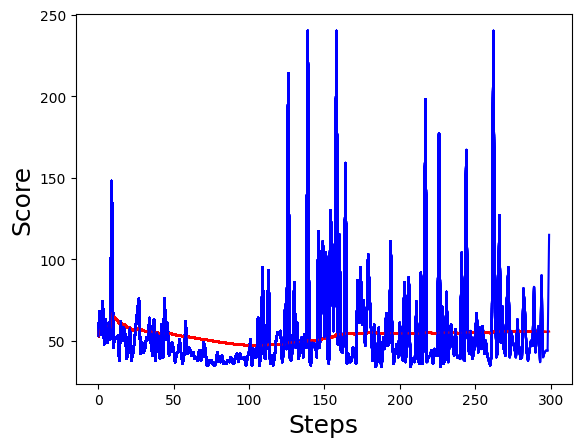

In [6]:
agent.train()

In [ ]:
agent.test("/home/cbeario/DeepPrior/drone-dqn.pt")